In [1]:
import overpy
import numpy as np
import fitparse
from rdp import rdp
import pandas as pd
import math
from geopy import distance
from tqdm import tqdm

# Import Fitfile and read all waypoints into array
+ and convert position into degrees

In [2]:
file = "Fahrt_am_Nachmittag.fit"
fitfile = fitparse.FitFile(file)
lat_long = []
for record in fitfile.get_messages("record"):
    lat_long.append([float(record.get_value('position_lat')) * 180 / math.pow(2, 31), float(record.get_value('position_long')) * 180 / math.pow(2, 31)])

# Optimze Map by using rdp to reduce requests:

In [3]:
def optimize(lat_long, EPSILON=0.0001):
    arr = np.array(list(map(lambda lat, lon: [lat, lon], lat_long[0], lat_long[1])))
    mask = rdp(arr, algo="iter", return_mask=True, epsilon=EPSILON)
    parr = np.array(lat_long)
    r = list(parr[mask])
    return r

In [4]:
# slicing array due private area reasons
df = pd.DataFrame(lat_long[500:-500])
# optimize array
_optimized = optimize(df)
print(f'Rawfile: {len(lat_long)} Points')
print(f'Optimized: {len(_optimized)} Points')


Rawfile: 6223 Points
Optimized: 99 Points


# Variant 1:

Build Query with all Waypoints and add distance to array for DataFrame usage

In [5]:
around = 5
tmp = []
s = ""
for a in range(0, len(_optimized )-1):
    tmp.append( [_optimized [a][0],  _optimized [a][1], distance.distance((_optimized [a][0], _optimized [a][1]), (_optimized [a+1][0], _optimized [a+1][1])).km])
    lat_mean = ( _optimized [a][0] + _optimized [a+1][0] ) / 2
    lon_mean = ( _optimized [a][1] + _optimized [a+1][1] ) / 2
    s += f"way['surface'](around:{around},{lat_mean}, {lon_mean});"
q = f"[out:json];({s});out;"

In [6]:
#print(q)

In [7]:
_df = pd.DataFrame(tmp, columns=['lat','lon','distance'])
_df

,lat,lon,distance
0,51.976537,7.601682,1.088618
1,51.983330,7.590279,0.138327
2,51.984269,7.588961,0.054852
3,51.984523,7.588277,1.042844
4,51.990946,7.577222,0.247170
...,...,...,...
93,52.192706,7.446302,0.040392
94,52.192563,7.446845,0.891835
95,52.193789,7.459733,0.235076
96,52.192914,7.462863,0.383535


In [8]:
_df['distance'].mean()

0.4608118063724402

# Query overpass by using generated long query

In [9]:
api = overpy.Overpass()
result = api.query(q)

In [10]:
len( result.ways )

47

In [11]:
for way in result.ways:
    if 'name' in way.tags.keys() and 'surface' in way.tags.keys():
        print(f"{way.tags['name']}: {way.tags['surface']}")

Lönsstraße: asphalt
Waldweg: asphalt
Rote Erde: asphalt
Torfvenn: asphalt
Im Venn: asphalt
Westfalenring: asphalt
Europaring: asphalt
Kampelweg: asphalt
Borghorster Straße: asphalt
Borghorster Straße: asphalt
Emsdettener Straße: asphalt
Emsdettener Straße: asphalt
Steinfurter Straße: asphalt
Waldweg: asphalt
Wettringer Straße: asphalt
RadBahn Münsterland: asphalt
Burgsteinfurter Straße: asphalt
RadBahn Münsterland: asphalt
Landfahrerplatz Nienberge: compacted
Altenberger Straße: asphalt
Burgsteinfurter Straße: asphalt
Europaring: asphalt
Sepp-Herberger-Straße: asphalt
Westfalenring: asphalt
Westfalenring: asphalt
Altenberger Straße: asphalt
Liedekerker Straße: asphalt
Wasserstraße: asphalt
Borghorster Straße: asphalt
RadBahn Münsterland: asphalt


Todo:
- Sort way to DataFrame index
- Calculate surface in P%

# Variant 2. 
Loop through Dataframe and get nearest way. One reuquest for one Waypoint in optimized track.

In [12]:
def get_way(lat,lon):
    # load balancing requests
    urls = ['https://lz4.overpass-api.de/api/interpreter', 'https://z.overpass-api.de/api/interpreter', 'https://maps.mail.ru/osm/tools/overpass/api/interpreter', 'https://overpass.openstreetmap.ru/api/interpreter', 'https://overpass.kumi.systems/api/interpreter']
    
    around = 10
    _name = None
    _surface = None
    s = f"way['surface'](around:{around},{lat}, {lon});"
    _query = f"[out:json];({s});out;"
    api = overpy.Overpass(url=np.random.choice(urls))
    result = api.query(_query)
    
    if len(result.ways) > 0:
        way = result.ways[0]
        if "name" in way.tags.keys():
            _name = way.tags['name']
        if "surface" in way.tags.keys():
            _surface = way.tags['surface']
    return [_name, _surface]

In [13]:
# loop dataframe and catch nearest street. Much more requests than variant 1
for index, x in tqdm( _df[['lat','lon']].iterrows(), total=_df.shape[0]):
    r =  get_way(x['lat'], x['lon']) 
    _df.loc[index, 'street_name'] = r[0]
    _df.loc[index, 'surface'] = r[1]

100%|██████████| 98/98 [00:55<00:00,  1.76it/s]


In [14]:
_df.tail()

,lat,lon,distance,street_name,surface
93,52.192706,7.446302,0.040392,Torfvenn,asphalt
94,52.192563,7.446845,0.891835,Torfvenn,asphalt
95,52.193789,7.459733,0.235076,Torfvenn,asphalt
96,52.192914,7.462863,0.383535,Torfvenn,asphalt
97,52.189527,7.463905,0.223215,Im Venn,asphalt


In [15]:
np.unique( _df['surface'].dropna() )

array(['asphalt', 'cobblestone', 'compacted', 'grass', 'paving_stones'],
      dtype=object)

In [16]:
summary_df = pd.DataFrame()
for s in np.unique( _df['surface'].dropna() ):
    summary_df.loc[0, s] = (_df['distance'].loc[_df['surface'] == s]).sum()

In [17]:
# Distance by surface
summary_df

,asphalt,cobblestone,compacted,grass,paving_stones
0,40.42923,0.111936,0.030319,0.340597,1.000677


In [18]:
# get in P%
summary_df.apply(lambda x: x/_df['distance'].sum()*100 )

,asphalt,cobblestone,compacted,grass,paving_stones
0,89.525303,0.247868,0.067137,0.754207,2.215869


<AxesSubplot: >

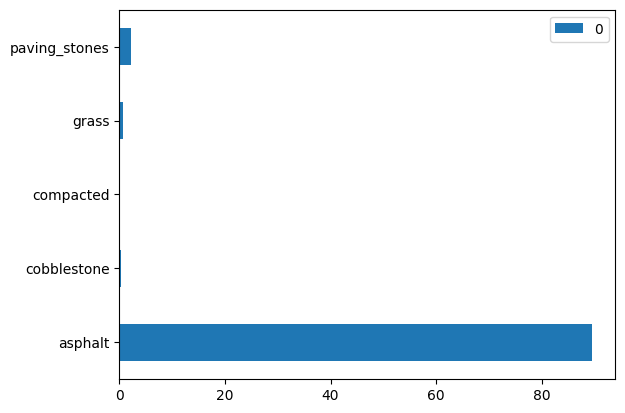

In [20]:
summary_df.apply(lambda x: x/_df['distance'].sum()*100 ).T.plot(kind="barh")